# fig — ood (develop)

**Motivation**: host = ```mach```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from figures.analysis import *

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

In [3]:
fig_base_dir = pjoin(fig_base_dir, 'iclr_oct02', 'ood')
os.makedirs(fig_base_dir, exist_ok=True)
print(os.listdir(fig_base_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

[]

## VAE: amort and iterative

### iP-VAE

In [4]:
mnist_to_load = get_mnist_models(device)
print(sorted(mnist_to_load))

[
    '<conv|conv>_(16,8.0)',
    '<conv|conv>_(4,1.5)',
    '<jacob|conv>_(16,8.0)',
    '<jacob|conv>_(2,0.75)',
    '<jacob|conv>_(4,1.5)',
    '<jacob|mlp>_(16,8.0)',
    '<jacob|mlp>_(4,1.5)',
    '<jacob|mlp>_(64,24.0)',
    '<mlp|mlp>_(16,8.0)',
    '<mlp|mlp>_(4,1.5)',
    '<mlp|mlp>_(64,24.0)'
]

In [5]:
selected_models = [
    '<jacob|mlp>_(64,24.0)',
    '<mlp|mlp>_(64,24.0)',
]

In [6]:
trainers = {}
for model_name in selected_models:
    trainers[model_name] = load_model(
        **mnist_to_load[model_name])[0]

In [7]:
from analysis.ood import ood_analysis

100%|█████████████████████████████████| 14/14 [02:11<00:00,  9.42s/it]


______________________________________________________________________________________________________________

mode: <jacob|mlp>_(64,24.0) ——— target: EMNIST
mse:    13.10
accuracy:       0.765

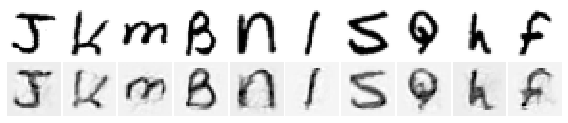

100%|███████████████████████████████████| 9/9 [01:30<00:00, 10.01s/it]


______________________________________________________________________________________________________________

mode: <jacob|mlp>_(64,24.0) ——— target: Omniglot
mse:    18.91
accuracy:       0.001

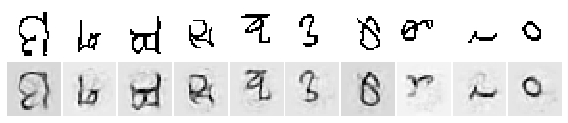

100%|█████████████████████████████████| 14/14 [00:08<00:00,  1.59it/s]


______________________________________________________________________________________________________________

mode: <mlp|mlp>_(64,24.0) ——— target: EMNIST
mse:    143.15
accuracy:       0.398

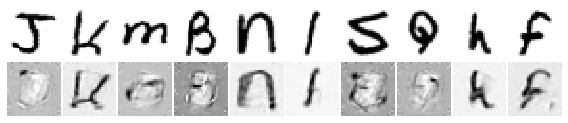

100%|███████████████████████████████████| 9/9 [00:05<00:00,  1.65it/s]


______________________________________________________________________________________________________________

mode: <mlp|mlp>_(64,24.0) ——— target: Omniglot
mse:    73.87
accuracy:       0.001

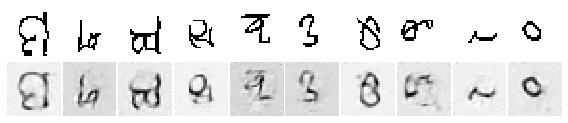

CPU times: user 20min 10s, sys: 3min 4s, total: 23min 15s
Wall time: 6min 18s


In [8]:
%%time

rng = get_rng(1)

inds = {}
shuffle_inds = {}
for model_name, tr in trainers.items():
    tr.cfg.batch_size = 1500
    t_recon = 1000 if tr.model.cfg.enc_type == 'jacob' else -1
    for ds_tgt in ['EMNIST', 'Omniglot']:
        accuracy, results = ood_analysis(
            tr=tr,
            dataset=ds_tgt,
            n_data_batches=None,
            t_clf=-1,
            t_recon=t_recon,
            verbose=True,
        )
        n_samples = len(results['recon'])
        
        print('_' * 110)
        msg = '\n'.join([
            f"mode: {model_name} ——— target: {ds_tgt}",
            f"mse:\t{results['mse'][-1]:0.2f}",
            f"accuracy:\t{accuracy:0.3f}",
        ])
        print(msg)

        vld = make_dataset(ds_tgt, 'cpu')[1]
        
        if ds_tgt not in inds:
            _shuffle_inds = np.arange(n_samples)
            rng.shuffle(_shuffle_inds)
            shuffle_inds[ds_tgt] = _shuffle_inds
            inds[ds_tgt] = first_occurrence_inds(
                vld.tensors[1][_shuffle_inds])
    
        src = tonp(vld.tensors[0])[:n_samples][shuffle_inds[ds_tgt]]
        recon = results['recon'][:, -1][shuffle_inds[ds_tgt]]
        recon = recon.reshape(tr.model.cfg.shape)

        x2p = np.concatenate([src[inds[ds_tgt]], recon[inds[ds_tgt]]])
        _ = plot_weights(x2p, nrows=2, cmap='Greys', vmin=0.001, vmax=1, dpi=70)

        print('\n\n')

In [9]:
n_samples

13180

In [10]:
len(shuffle_inds[ds_tgt])

13180

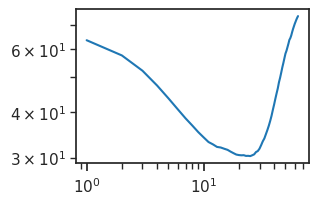

In [11]:
plt.loglog(np.arange(1, 1 + len(results['mse'])), results['mse']);

In [13]:
len(results['mse'])

64

mse:    13.09
accuracy:       0.764

mse:    19.22
accuracy:       0.001

In [35]:
results['recon'].shape

(20800, 1000, 784)

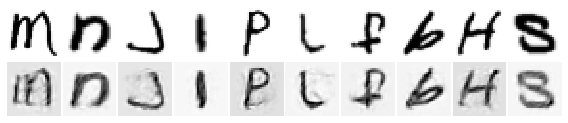

In [54]:
datasets = ['MNIST', 'EMNIST', 'Omniglot']
for ds_src, ds_tgt in itertools.permutations(datasets, 2):
    print(ds_src, ds_tgt)

MNIST EMNIST

MNIST Omniglot

EMNIST MNIST

EMNIST Omniglot

Omniglot MNIST

Omniglot EMNIST

In [ ]:
corrupt_dir = "/Data/hadi/corrupted_data/"
eval_dir = "/Data/hadi/eval_results/rot/"
fs_c = [i for i in os.listdir(corrupt_dir) if i[-3:] == "npz" and "rotate" in i]
fs = [i for i in os.listdir(eval_dir)]
requested_dsets = ["mnist"]
requested_dsets = [i.lower() for i in requested_dsets]
for f in tqdm(fs):
    broken = f.split("_")
    proj = broken[0]
    if proj in ["MARINO", "SAVAE"]:
        ds = broken[1] 
        if ds.lower() in requested_dsets:
            rotation = broken[2]
            rotation_fl = f"{ds}_{rot}.npz"
            
            if proj == "MARINO":
                model = broken[-2] #either H or SL
            loaded = np.load(eval_dir+f)
            recons = loaded["recons"] #shape N, 1, h, w
            posteriors = loaded["posteriors"] #shape M, t, 2, d